### Imports necesarios

In [51]:
# Useful libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Hyperparameter tuning.
from sklearn.model_selection import GridSearchCV

# Metrics.
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn import metrics

### Miscellaneous functions

In [52]:
# Read a cut of the dataset, it assumes that there is going to be four files in the directory,
#   called "xTrain", "xTest", "yTrain", "yTest".
def readCut(dir):
    xTrain = pd.read_csv("{}/xTrain.csv".format(dir), sep=',', error_bad_lines=True, index_col=False, dtype='unicode')
    yTrain = pd.read_csv("{}/yTrain.csv".format(dir), sep=',', error_bad_lines=True, index_col=False, dtype='unicode')
    xTest  = pd.read_csv( "{}/xTest.csv".format(dir), sep=',', error_bad_lines=True, index_col=False, dtype='unicode')
    yTest  = pd.read_csv( "{}/yTest.csv".format(dir), sep=',', error_bad_lines=True, index_col=False, dtype='unicode')

    return xTrain, yTrain, xTest, yTest

# Entries names for the result dictionary.
_accuracy   = "Accuracy"
_precision  = "Precision"
_recall     = "Recall"
_f1         = "F1"
_fpr        = "FPR"
_tpr        = "TPR"
_thresholds = "Thresholds"
_auc        = "AUC"
_roc        = "ROC"
_model      = "Model"
_min_iter   =   'min_cut_iter' 
_max_iter   =   'max_cut_iter' 
_model_min  =   'model_min'
_model_max  =   'model_max'

#Dictionary for visualization ROC
_vis_minMetrics  =   'minMetrics' 
_vis_minModel    =   'minModel' 
_vis_maxMetrics  =   'maxMetrics'
_vis_maxModel    =   'maxModel' 
_vis_pathMin     =   'pathMin'  
_vis_pathMax     =   'pathMax'  

# Metrics array.
_metrics = [_accuracy, _precision, _recall, _f1, _auc]

# Names of the feature enginereed datastes.
_normalized   = "Normalized"
_standardized = "Standardized"
_betterFE     = "BetterFE"

# Datasets array.
_datasets = [_normalized, _standardized, _betterFE]
#_datasets = [_normalized]

# Entries names for the calculated results.
_min  = "Min"
_max  = "Max"
_mean = "Mean"

# Function to process the results of a model, to get a better print of them.
def processAlgorithmResults(resultDictionary):

    calculatedResultsDictionary = {}

    # Process the results for every feature engineed dataset.
    for dataset in _datasets:

        # Set the current dataset entry.
        calculatedResultsDictionary[dataset] = {}

        # Process every metric.
        for metric in _metrics:

            # Store the metric values.
            metricValues = []
            classifiers = []
            # Process the results for every cut.
            for cut in resultDictionary[dataset]:

                # Get the specific metric value for the current cut.
                metricValues.append(cut[metric])
                classifiers.append(cut[_model])

            # Get the calculated results.
            min_it = np.argmin(metricValues)
            max_it = np.argmax(metricValues)
            calculatedResultsDictionary[dataset][metric] = {
                _min        : min(metricValues),
                _max        : max(metricValues),
                _mean       : sum(metricValues) / len(metricValues),
                _min_iter   : int(min_it + 1),
                _max_iter   : int(max_it + 1),
                _model_min  : classifiers[min_it],
                _model_max  : classifiers[max_it]
            }

    return calculatedResultsDictionary

In [53]:
def plotVis(diccionary):
    metrics = diccionary[i][_vis_minMetrics]
    model = diccionary[i][_vis_minModel]
    path = diccionary[i][_vis_pathMin]

    xTrain, yTrain, xTest, yTest = readCut(path)
    print(metrics)
    plot_roc_curve(model, xTest, yTest)
    plt.show(block = False)

    metrics = diccionary[i][_vis_maxMetrics]
    model = diccionary[i][_vis_maxModel]
    path = diccionary[i][_vis_pathMax]

    xTrain, yTrain, xTest, yTest = readCut(path)
    print(metrics)
    plot_roc_curve(model, xTest, yTest)
    plt.show(block = False)

In [54]:
def plotROC(calculatedResults, fullDicc):
        for dataset in _datasets:
                metric_values_min = {
                }
                metric_values_max = {
                }
                print("Dataset : " + dataset)
                cut_with_min_value  = calculatedResults[dataset][_auc][_min_iter]
                model_min =calculatedResults[dataset][_auc][_model_min]
                pathMin = os.path.join(dataset, "cut" + str(cut_with_min_value))

                cut_with_max_value  = calculatedResults[dataset][_auc][_max_iter]
                model_max =calculatedResults[dataset][_auc][_model_max]
                pathMax = os.path.join(dataset, "cut" + str(cut_with_max_value))
                
                for metrics in _metrics:
                        metric_values_min[metrics] = fullDicc[dataset][cut_with_min_value][metrics]
                        metric_values_max[metrics] = fullDicc[dataset][cut_with_max_value][metrics]
                dicc_plot = {
                        _vis_minMetrics : metric_values_min,
                        _vis_minModel   : model_min,
                        _vis_maxMetrics : metric_values_max,
                        _vis_maxModel   : model_max,
                        _vis_pathMin    : pathMin,
                        _vis_pathMax    : pathMax
                }
                
                plotVis(dicc_plot)


# Definition of the models
Each of the following functions is responsible for instantiating the model, defining the parameter grid to find the best parameters, and training the model with the best parameters to make predictions and calculate metrics.

### Logistic Regression

In [55]:
def doLogisticRegression(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    logisticRegression = LogisticRegression()

    # Definition of the parameter grid.
    param_grid = [{'penalty':['l2'],
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'max_iter':[100, 500, 1000],
                'fit_intercept' : [True, False]
    }]
    logreg_cv = GridSearchCV(logisticRegression, param_grid, n_jobs=-1)
    
    # Fit the model.
    logreg_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", logreg_cv.best_params_)

    # Predict using the model.
    yPred = logreg_cv.predict(xTest)
   

    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yPred),
       _model      : logreg_cv
    }

    return dicResult


### K-Nearest-Neighbor

In [56]:
def doKNN(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    knn = KNeighborsClassifier()

    # Definition of the parameter grid.
    param_grid = [{'n_neighbors':[i for i in range(3,11)],
                'weights' : ['uniform', 'distance'],
                'algorithm' : ['ball_tree', 'kd_tree'],
                'leaf_size' : [i for i in range(20,41)],
                'metric' : ['euclidean', 'manhattan', 'chebyshev']
    }]
    knn_cv=GridSearchCV(knn, param_grid, n_jobs=-1)

    # Fit the model.
    knn_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", knn_cv.best_params_)

    # Predict using the model.
    yPred = knn_cv.predict(xTest)
    _yPred = np.array([int(y) for y in yPred])

    # Execute ROC.
    fpr, tpr, thresh = roc_curve(yTest.values.ravel(), _yPred, pos_label='1')

    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _fpr        : fpr,
       _tpr        : tpr,
       _thresholds : thresh,
       _auc        : roc_auc_score(yTest.values.ravel(), yPred),
       _model      : knn_cv
    }

    return dicResult

### Decision Tree

In [57]:
def doDecisionTree(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    decisionTree = DecisionTreeClassifier()

    # Definition of the parameter grid.
    param_grid = [{'criterion':['gini', 'entropy'],
                'max_depth': np.arange(3,15).tolist() + [None],
                'splitter' : ['best', 'random'],
                'max_features' : ['sqrt', 'log2', None]
    }]
    decisionTree_cv=GridSearchCV(decisionTree, param_grid, n_jobs=-1)

    # Fit the model.
    decisionTree_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", decisionTree_cv.best_params_)

    # Predict using the model.
    yPred = decisionTree_cv.predict(xTest)
    _yPred = np.array([int(y) for y in yPred])

    # Execute ROC.
    fpr, tpr, thresh = roc_curve(yTest.values.ravel(), _yPred, pos_label='0')

    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _fpr        : fpr,
       _tpr        : tpr,
       _thresholds : thresh,
       _auc        : roc_auc_score(yTest.values.ravel(), yPred),
       _model      : decisionTree_cv
    }

    return dicResult

### Neural Network

In [58]:
def doNeuralNetwork(xTrain, yTrain, xTest, yTest):

    # Model instantiation.
    nnClassifier = MLPClassifier(max_iter=500)
    
    # Definition of the parameter grid.
    # Use Saul's Heuristic for the amount of the hidden layers.
    numberFeatures = xTrain.shape[1]
    hiddenLayerAmount = np.arange(numberFeatures / 2, 2 * numberFeatures + 1)
    param_grid =[{
        'hidden_layer_sizes': [(10,30,10),(20,)],
        'activation': ['tanh', 'relu','logistic'],
        'solver': ['sgd', 'adam'],
        'max_iter': [1000,1500],
        'alpha': [0.0001, 0.05],
    }]
    nnClassifier_cv = GridSearchCV(nnClassifier, param_grid, n_jobs=-1)

    # Fit the model.
    nnClassifier_cv.fit(xTrain, yTrain.values.ravel())
    #print("Tuned hyperparameters (best parameters): ", nnClassifier_cv.best_params_)

    # Predict using the model.
    yPred = nnClassifier_cv.predict(xTest)
    _yPred = np.array([int(y) for y in yPred])

    # Execute ROC.
    fpr, tpr, thresh = roc_curve(yTest.values.ravel(), _yPred, pos_label='0')

    # Process the metrics.
    dicResult = {
       _accuracy   : accuracy_score(yTest.values.ravel(), yPred),
       _precision  : precision_score(yTest.values.ravel(), yPred, pos_label='1'),
       _recall     : recall_score(yTest.values.ravel(), yPred, pos_label='1'),
       _f1         : f1_score(yTest.values.ravel(), yPred, pos_label='1'),
       _auc        : roc_auc_score(yTest.values.ravel(), yPred),
       _model      : nnClassifier_cv
    }

    return dicResult

# Run algorithms
We are going to run each algorithm for every cut for every feature engineered dataset.

### Logistic regression

In [47]:
print("Running logistic regression...")

# Dictionary for the logistic regression results.
logisticRegressionResults = {
    _normalized : [],
    _standardized : [],
    _betterFE : []
}

# Run the algorithm for ...
# For every feature engineered dataset.
for i in _datasets:
    print("Start for", i, "dataset")

    # For every cut.
    for j in range(1, 6):

        # Build the dir.
        path = os.path.join(i, "cut" + str(j))

        # Get the cut from disk.
        xTrain, yTrain, xTest, yTest = readCut(path)

        # Run logistic regression for the curren cut and get the metrics.
        partialResult = doLogisticRegression(xTrain, yTrain, xTest, yTest)
        # Store the metrics for the current feature engineered dataset.
        logisticRegressionResults[i].append(partialResult)

        print("\tDone cut:", path)

# Get the calculated mean, the min and the max for every metric.
logisticRegressionCalculatedResults = processAlgorithmResults(logisticRegressionResults)

Running logistic regression...
Start for Normalized dataset
	Done cut: Normalized\cut1
	Done cut: Normalized\cut2
	Done cut: Normalized\cut3
	Done cut: Normalized\cut4
	Done cut: Normalized\cut5
Start for Standardized dataset
	Done cut: Standardized\cut1
	Done cut: Standardized\cut2
	Done cut: Standardized\cut3
	Done cut: Standardized\cut4
	Done cut: Standardized\cut5
Start for BetterFE dataset
	Done cut: BetterFE\cut1
	Done cut: BetterFE\cut2
	Done cut: BetterFE\cut3
	Done cut: BetterFE\cut4
	Done cut: BetterFE\cut5


Summary

In [48]:
# Print the results for every dataset.
for dataset in _datasets:
    # Create a panda frame to pretty print.
    frame = pd.DataFrame(logisticRegressionCalculatedResults[dataset])
    
    #Delete models for pretty print
    frame.drop(_model_min, inplace=True)
    frame.drop(_model_max, inplace=True)
    # Print the frame.
    print(frame)

              Accuracy Precision    Recall        F1
Min           0.703125  0.734463  0.695906  0.714715
Max            0.80625  0.818713  0.818713  0.818713
Mean           0.74875  0.772022  0.752047   0.76162
min_cut_iter         1         2         1         1
max_cut_iter         4         4         4         4
             Accuracy Precision    Recall        F1
Min            0.7125  0.730994  0.730994  0.730994
Max             0.775  0.827815  0.777778  0.780059
Mean            0.745  0.770923  0.746199  0.757941
min_cut_iter        4         4         1         4
max_cut_iter        5         5         3         3
              Accuracy Precision    Recall        F1
Min            0.68231  0.701987  0.630872  0.701493
Max           0.765343  0.808824  0.738255   0.77193
Mean          0.727076  0.770613  0.704698  0.735147
min_cut_iter         2         2         5         5
max_cut_iter         4         4         4         4


Plot ROC - Logistic Regression

Dataset : Normalized

Roc plot for cut 1
Model with min values for metrics:
['Accuracy', 'Recall', 'F1']


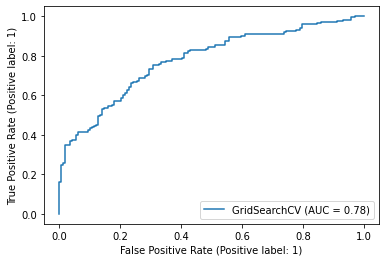


Roc plot for cut 2
Model with min values for metrics:
['Precision']


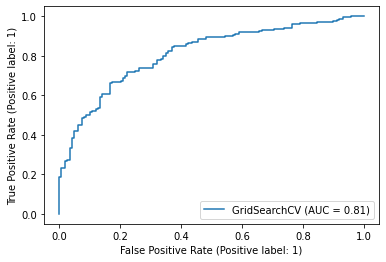


Roc plot for cut 4
Model with max values for metrics:
['Accuracy', 'Precision', 'Recall', 'F1']


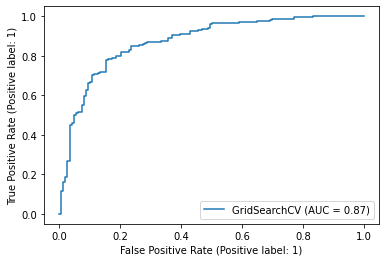

Dataset : Standardized

Roc plot for cut 1
Model with min values for metrics:
['Recall']


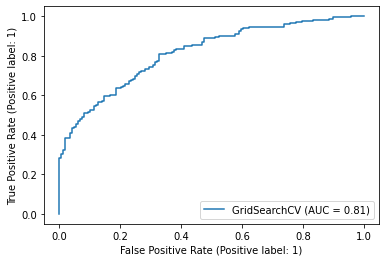


Roc plot for cut 3
Model with max values for metrics:
['Recall', 'F1']


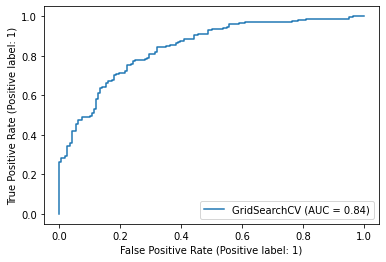


Roc plot for cut 4
Model with min values for metrics:
['Accuracy', 'Precision', 'F1']


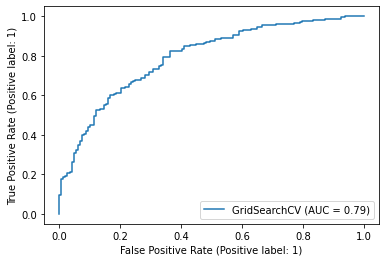


Roc plot for cut 5
Model with max values for metrics:
['Accuracy', 'Precision']


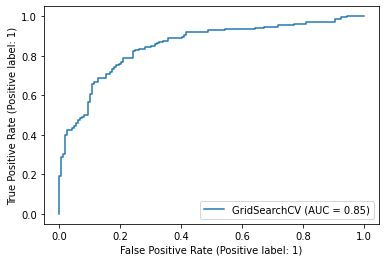

Dataset : BetterFE

Roc plot for cut 2
Model with min values for metrics:
['Accuracy', 'Precision']


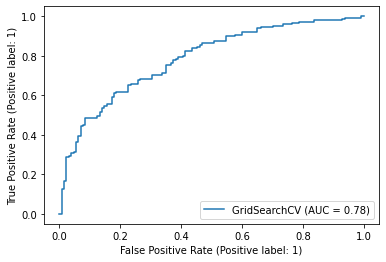


Roc plot for cut 4
Model with max values for metrics:
['Accuracy', 'Precision', 'Recall', 'F1']


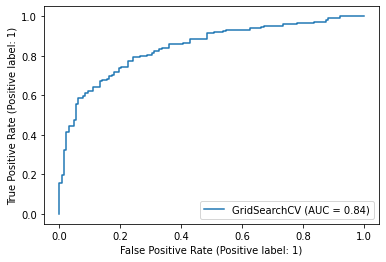


Roc plot for cut 5
Model with min values for metrics:
['Recall', 'F1']


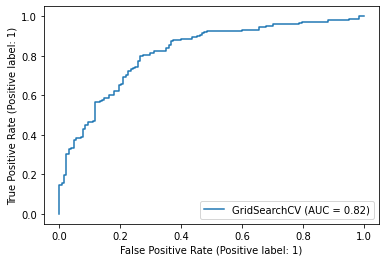

In [49]:
plotROC(logisticRegressionCalculatedResults, logisticRegressionResults)

In [50]:
print("Done!")

Done!
